In [1]:
import pandas as pd

# 读取数据
df = pd.read_excel('Online Retail.xlsx')

# 查看数据基本信息
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    

In [2]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 1. 指定本地中文字体路径（Windows 通常用微软雅黑）
font_path = "C:/Windows/Fonts/msyh.ttc"  # 微软雅黑字体路径
font_prop = FontProperties(fname=font_path)

# 2. 设置全局默认字体
plt.rcParams['font.family'] = font_prop.get_name()

# 3. 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False


In [3]:
# 保留Quantity > 0的订单（排除退货等负数）
df = df[df['Quantity'] > 0]

# 转换时间格式
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 确认CustomerID无缺失，用户ID作为UserID
df = df[df['CustomerID'].notnull()]
df['UserID'] = df['CustomerID'].astype(int)


In [6]:
register_date = df.groupby('UserID')['InvoiceDate'].min().reset_index()
register_date.columns = ['UserID', 'RegisterDate']

print(register_date.head())


   UserID        RegisterDate
0   12346 2011-01-18 10:01:00
1   12347 2010-12-07 14:57:00
2   12348 2010-12-16 19:09:00
3   12349 2011-11-21 09:51:00
4   12350 2011-02-02 16:01:00


In [7]:
# 确保register_date只包含UserID和RegisterDate
register_date = register_date[['UserID', 'RegisterDate']]

# 合并时指定后缀避免冲突
df = df.merge(register_date, on='UserID', how='left', suffixes=('', '_reg'))

# 使用合并后的注册时间列，这里用RegisterDate_reg
df['RegisterDate_reg'] = pd.to_datetime(df['RegisterDate_reg'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 只保留日期部分
df['RegisterDate_reg'] = df['RegisterDate_reg'].dt.floor('D')
df['PurchaseDate'] = df['InvoiceDate'].dt.floor('D')

# 计算天数差
df['DaysSinceRegister'] = (df['PurchaseDate'] - df['RegisterDate_reg']).dt.days

print(df[['UserID', 'RegisterDate_reg', 'PurchaseDate', 'DaysSinceRegister']].head(10))


   UserID RegisterDate_reg PurchaseDate  DaysSinceRegister
0   17850       2010-12-01   2010-12-01                  0
1   17850       2010-12-01   2010-12-01                  0
2   17850       2010-12-01   2010-12-01                  0
3   17850       2010-12-01   2010-12-01                  0
4   17850       2010-12-01   2010-12-01                  0
5   17850       2010-12-01   2010-12-01                  0
6   17850       2010-12-01   2010-12-01                  0
7   17850       2010-12-01   2010-12-01                  0
8   17850       2010-12-01   2010-12-01                  0
9   13047       2010-12-01   2010-12-01                  0


In [8]:
register_counts = df[df['DaysSinceRegister'] == 0].groupby('RegisterDate')['UserID'].nunique()
print(register_counts.head())


RegisterDate
2010-12-01 08:26:00    1
2010-12-01 08:34:00    1
2010-12-01 08:45:00    1
2010-12-01 09:00:00    1
2010-12-01 09:09:00    1
Name: UserID, dtype: int64


In [9]:
def retention_rate(day):
    active_counts = df[df['DaysSinceRegister'] == day].groupby('RegisterDate')['UserID'].nunique()
    retention = active_counts / register_counts
    return retention.fillna(0)


In [10]:
retention_days = [1, 3, 7, 14, 30]

retention_df = pd.DataFrame()
for day in retention_days:
    retention_df[f'D{day}'] = retention_rate(day)

print(retention_df.head())


                      D1   D3   D7  D14  D30
RegisterDate                                
2010-12-01 08:26:00  1.0  0.0  0.0  0.0  0.0
2010-12-01 08:34:00  0.0  0.0  0.0  0.0  0.0
2010-12-01 08:45:00  0.0  0.0  0.0  0.0  0.0
2010-12-01 09:00:00  0.0  0.0  0.0  0.0  0.0
2010-12-01 09:09:00  0.0  0.0  1.0  0.0  0.0


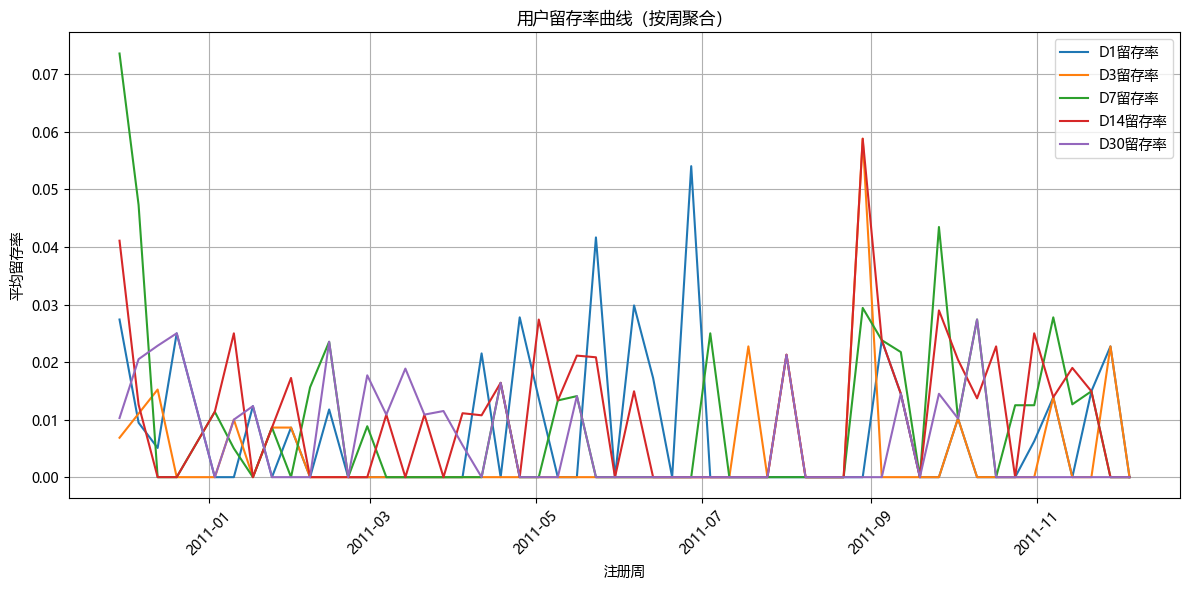

In [11]:
# 按周聚合：先把日期转换成周的开始日期（周一）
retention_weekly = retention_df.copy()
retention_weekly.index = retention_weekly.index.to_period('W').start_time

# 按周分组，计算平均留存率
retention_weekly = retention_weekly.groupby(retention_weekly.index).mean()

# 画图
plt.figure(figsize=(12, 6))
for day in retention_days:
    plt.plot(retention_weekly.index, retention_weekly[f'D{day}'], label=f'D{day}留存率')

plt.title('用户留存率曲线（按周聚合）')
plt.xlabel('注册周')
plt.ylabel('平均留存率')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


c:\Users\86135\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


         visit_count  total_quantity    avg_price
cluster                                          
0           3.916319      912.191006     3.997552
1           1.000000        1.000000  2033.100000
2          68.333333    51937.625000     4.008679


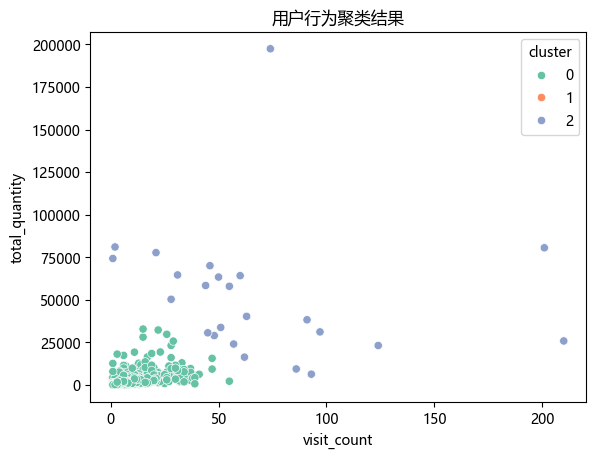

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 假设df是你的用户行为数据
# 这里演示从交易数据中构造行为指标
user_behavior = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',       # 访问次数（订单数）
    'Quantity': 'sum',            # 总购买数量
    'UnitPrice': 'mean'           # 平均单价
}).rename(columns={
    'InvoiceNo': 'visit_count',
    'Quantity': 'total_quantity',
    'UnitPrice': 'avg_price'
}).reset_index()

# 2. 特征标准化（可选，KMeans效果更好）
from sklearn.preprocessing import StandardScaler
features = ['visit_count', 'total_quantity', 'avg_price']
scaler = StandardScaler()
user_behavior_scaled = scaler.fit_transform(user_behavior[features])

# 3. 确定聚类数 k（这里假设先用3）
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
user_behavior['cluster'] = kmeans.fit_predict(user_behavior_scaled)

# 4. 查看每个簇的特征均值
cluster_summary = user_behavior.groupby('cluster')[features].mean()
print(cluster_summary)

# 5. 可视化聚类结果（2维散点图示例）
sns.scatterplot(x='visit_count', y='total_quantity', hue='cluster', data=user_behavior, palette='Set2')
plt.title('用户行为聚类结果')
plt.show()


In [13]:
for c in user_behavior['cluster'].unique():
    print(f"簇 {c} 用户样本预览：")
    print(user_behavior[user_behavior['cluster'] == c].head(5))
    print("\n")


簇 2 用户样本预览：
     CustomerID  visit_count  total_quantity  avg_price  cluster
0       12346.0            1           74215   1.040000        2
55      12415.0           21           77670   2.928883        2
326     12748.0          210           25748   2.655701        2
481     12971.0           86            9289   2.310328        2
562     13089.0           97           31070   2.737816        2


簇 0 用户样本预览：
   CustomerID  visit_count  total_quantity  avg_price  cluster
1     12347.0            7            2458   2.644011        0
2     12348.0            4            2341   5.764839        0
3     12349.0            1             631   8.289041        0
4     12350.0            1             197   3.841176        0
5     12352.0            8             536  15.930706        0


簇 1 用户样本预览：
      CustomerID  visit_count  total_quantity  avg_price  cluster
4014     17846.0            1               1     2033.1        1




In [14]:
# 构造用户行为特征
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['amount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDay'] = df['InvoiceDate'].dt.floor('D')

# 分组聚合
user_features = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # 访问次数
    'Quantity': 'sum',       # 购买数量
    'amount': 'sum',         # 总消费金额
    'StockCode': 'nunique',  # 商品种类数
    'InvoiceDay': 'nunique', # 活跃天数
    'InvoiceDate': 'max'     # 最近购买日期
}).rename(columns={
    'InvoiceNo': 'visit_count',
    'Quantity': 'total_quantity',
    'amount': 'total_amount',
    'StockCode': 'unique_items',
    'InvoiceDay': 'active_days',
    'InvoiceDate': 'last_purchase_date'
})

# 计算平均单价
user_features['avg_price'] = user_features['total_amount'] / (user_features['total_quantity'] + 1e-6)

# 最近一次购买距分析日（设定分析日为整个数据最大日期）
analysis_date = df['InvoiceDate'].max()
user_features['days_since_last_purchase'] = (analysis_date - user_features['last_purchase_date']).dt.days

# 去掉无用字段
user_features = user_features.drop(columns='last_purchase_date').reset_index()


In [15]:
import pandas as pd

# 设定数据结束日期（全局最大日期）
data_end_date = pd.to_datetime('2011-12-10')  # 可根据 df['InvoiceDate'].max() 自动计算

# 用户最后购买日期
last_purchase = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']

# 合并到用户特征表
user_behavior = user_features.merge(last_purchase, on='CustomerID', how='left')

# 计算距离结束日期的天数
user_behavior['DaysSinceLastPurchase'] = (data_end_date - user_behavior['LastPurchaseDate']).dt.days

# 设置流失标签：超过30天未购买为流失
user_behavior['is_churn'] = (user_behavior['DaysSinceLastPurchase'] > 30).astype(int)

# 查看统计情况
print(user_behavior['is_churn'].value_counts())


is_churn
1    2671
0    1668
Name: count, dtype: int64


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# 选择特征和标签
features = ['visit_count', 'total_quantity', 'avg_price']
X = user_behavior[features]
y = user_behavior['is_churn']

# 拆分训练集和测试集，随机种子固定，方便复现
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 初始化逻辑回归模型
model = LogisticRegression(max_iter=1000)

# 训练模型
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 输出指标
print(f"准确率: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(classification_report(y_test, y_pred))


准确率: 0.7335
AUC: 0.7796
              precision    recall  f1-score   support

           0       0.79      0.42      0.55       504
           1       0.72      0.93      0.81       798

    accuracy                           0.73      1302
   macro avg       0.76      0.68      0.68      1302
weighted avg       0.75      0.73      0.71      1302



In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, accuracy_score, roc_auc_score
import numpy as np

# 假设你已有特征X和标签y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 得到测试集的预测概率（概率数组，第二列是预测为正类的概率）
y_pred_prob = model.predict_proba(X_test)

# 计算precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])

# 计算F1，找最佳阈值
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"最佳阈值: {best_threshold:.3f}, 对应F1分数: {f1_scores[best_idx]:.3f}")

# 根据最佳阈值重新预测标签
y_pred_best = (y_pred_prob[:,1] >= best_threshold).astype(int)

# 输出指标
print("调整阈值后的结果：")
print(f"准确率: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_prob[:,1]):.4f}")
print(classification_report(y_test, y_pred_best))


最佳阈值: 0.414, 对应F1分数: 0.999
调整阈值后的结果：
准确率: 0.9985
AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       504
           1       1.00      1.00      1.00       798

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302



In [31]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# 假设你已有y_test, y_pred_prob（模型输出的概率）

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"最佳阈值: {best_threshold:.3f}, 对应F1分数: {f1_scores[best_idx]:.3f}")

# 用最佳阈值生成预测标签
y_pred_best = (y_pred_prob[:,1] >= best_threshold).astype(int)

# 重新计算指标
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

print("调整阈值后的结果：")
print(f"准确率: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_prob[:,1]):.4f}")
print(classification_report(y_test, y_pred_best))


最佳阈值: 0.414, 对应F1分数: 0.999
调整阈值后的结果：
准确率: 0.9985
AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       504
           1       1.00      1.00      1.00       798

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302



In [32]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# 假设X,y是你的特征和标签

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_clf.fit(X_train, y_train)

y_val_pred = xgb_clf.predict(X_val)
y_val_pred_prob = xgb_clf.predict_proba(X_val)

print(f"XGBoost 准确率: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"XGBoost AUC: {roc_auc_score(y_val, y_val_pred_prob[:,1]):.4f}")


XGBoost 准确率: 0.9946
XGBoost AUC: 1.0000


c:\Users\86135\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [15:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [33]:
from sklearn.model_selection import train_test_split

# 去除无关字段
feature_cols = ['visit_count', 'total_quantity', 'total_amount', 'unique_items', 'active_days', 'avg_price', 'days_since_last_purchase']
X = user_behavior[feature_cols]
y = user_behavior['is_churn']

# 划分训练/测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 输出评估指标
print("准确率:", model.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))


准确率: 0.9965437788018433
AUC: 0.9999720282849982
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       336
           1       1.00      1.00      1.00       532

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



In [35]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost 准确率:", xgb_model.score(X_test, y_test))
print("XGBoost AUC:", roc_auc_score(y_test, xgb_proba))
print(classification_report(y_test, xgb_pred))


XGBoost 准确率: 0.9953917050691244
XGBoost AUC: 0.999983216970999
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       336
           1       1.00      0.99      1.00       532

    accuracy                           1.00       868
   macro avg       0.99      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



c:\Users\86135\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [15:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


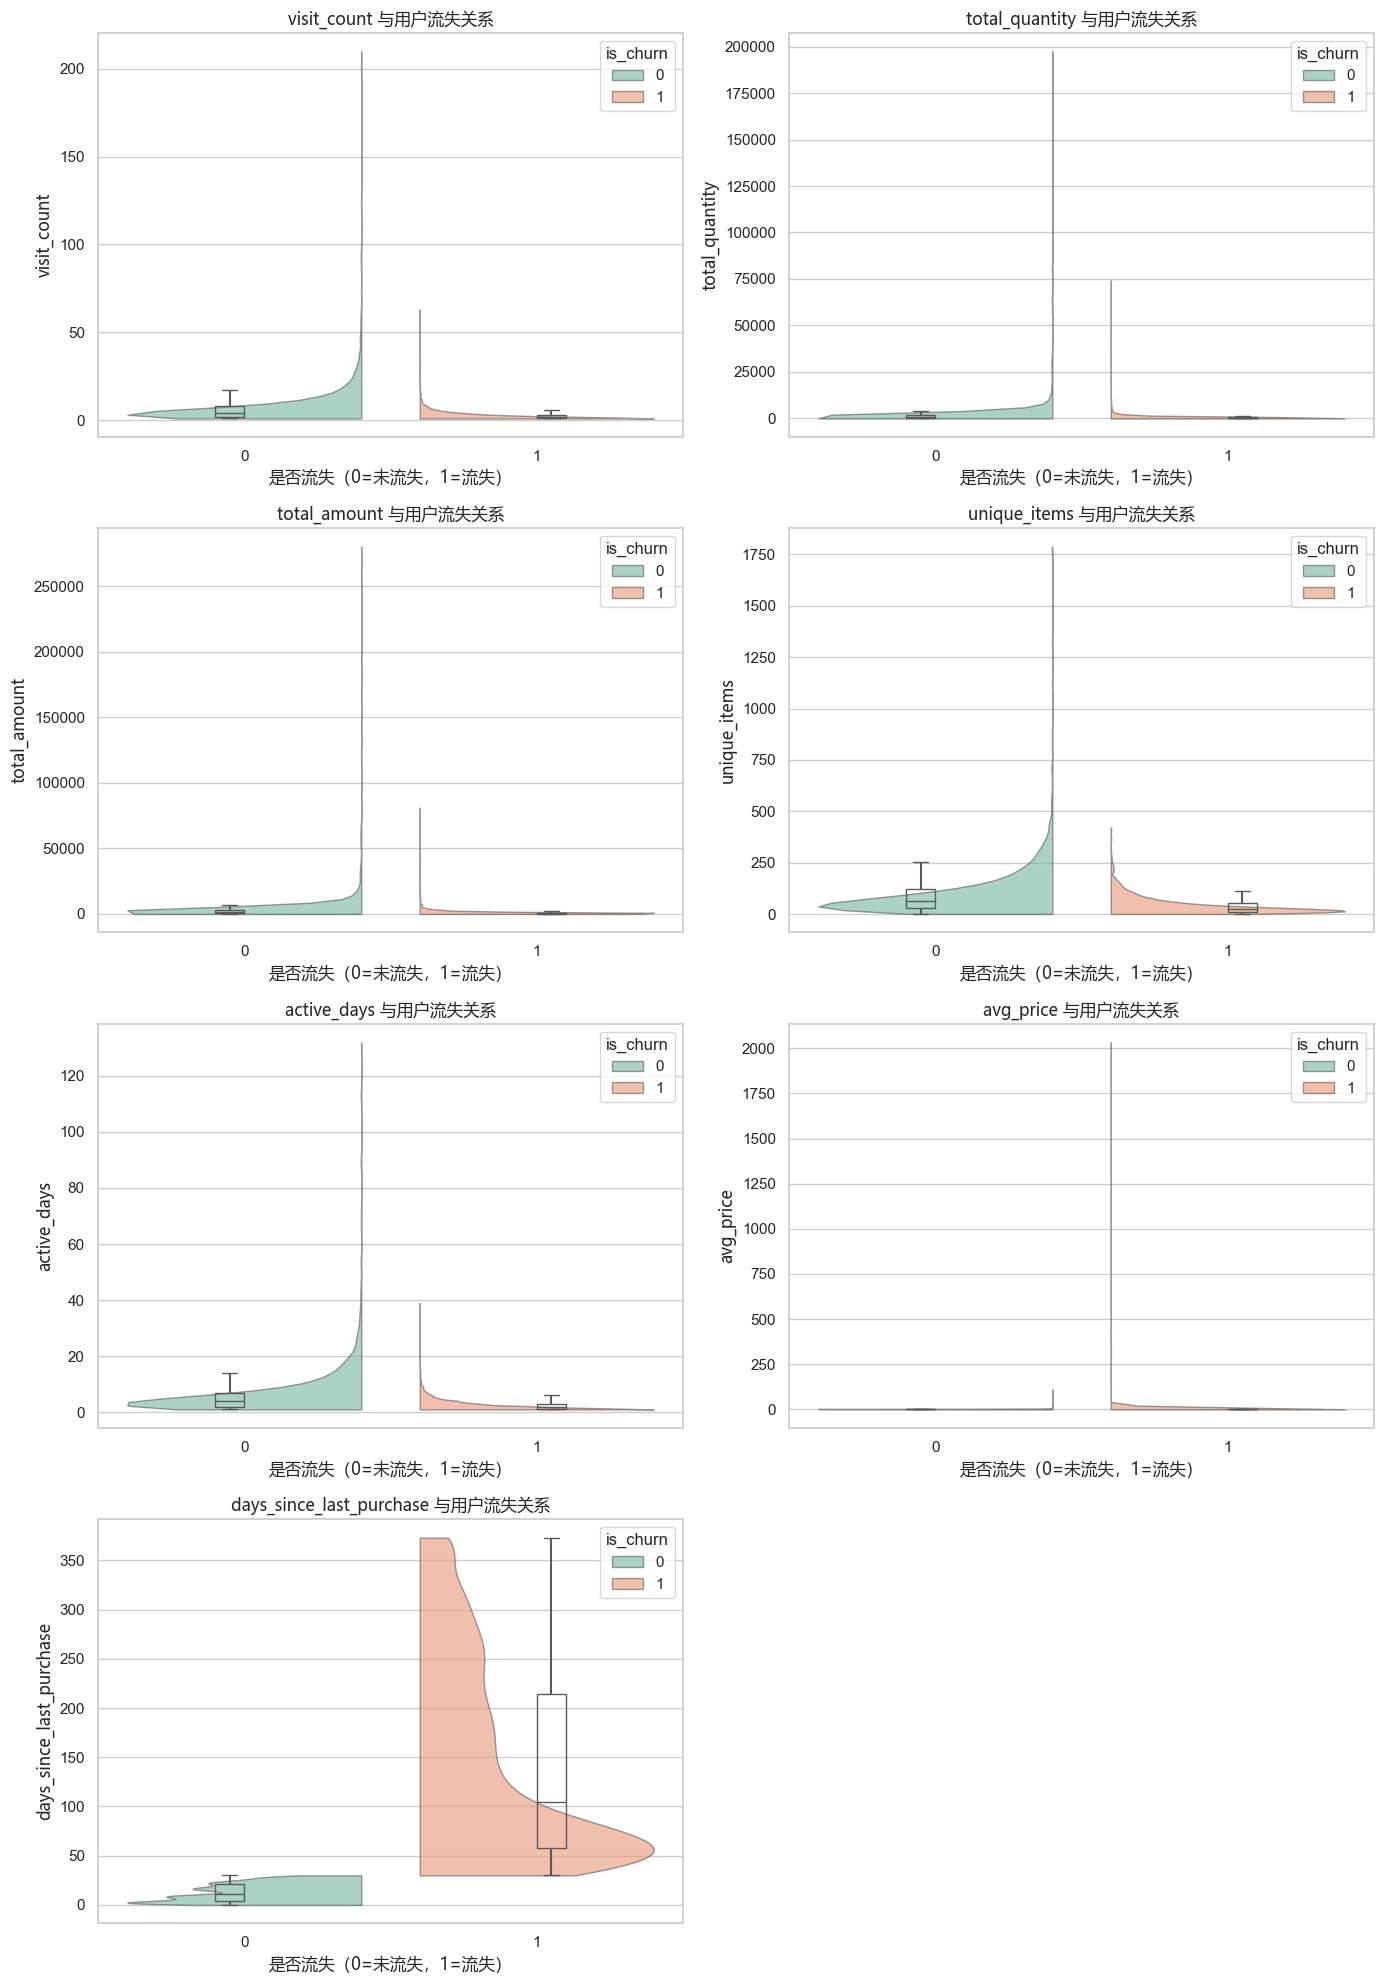

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 中文字体设置（如无中文显示问题可忽略）
font_path = "C:\\Windows\\Fonts\\msyh.ttc"  # 微软雅黑字体路径
font_prop = fm.FontProperties(fname=font_path, size=12)

sns.set(style="whitegrid")

features = ['visit_count', 'total_quantity', 'total_amount',
            'unique_items', 'active_days', 'avg_price', 'days_since_last_purchase']

n_features = len(features)
cols = 2
rows = (n_features + 1) // cols

plt.figure(figsize=(14, 5 * rows))

for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)

    # 画小提琴图，hue传入，palette对应色彩
    sns.violinplot(data=user_behavior,
                   x='is_churn', y=feature,
                   hue='is_churn', palette='Set2',
                   inner=None,  # 不显示内部点或箱线
                   cut=0,       # 不往外扩展
                   linewidth=1,
                   split=True,  # 两组对称显示（只有二分类适用）
                   alpha=0.6)

    # 画箱线图，hue传入，palette对应色彩，关闭图例
    sns.boxplot(data=user_behavior,
                x='is_churn', y=feature,
                hue='is_churn', palette='Set2',
                showcaps=True,
                boxprops={'facecolor':'none'},  # 让箱线透明
                showfliers=False,
                whiskerprops={'linewidth':1.5},
                saturation=1,
                width=0.2,
                dodge=True,
                legend=False)

    plt.title(f"{feature} 与用户流失关系", fontproperties=font_prop)
    plt.xlabel("是否流失（0=未流失，1=流失）", fontproperties=font_prop)
    plt.ylabel(feature, fontproperties=font_prop)

plt.tight_layout()
plt.show()


In [37]:
print(user_behavior['days_since_last_purchase'].describe())

count    4339.000000
mean       91.518322
std       100.009747
min         0.000000
25%        17.000000
50%        50.000000
75%       141.000000
max       373.000000
Name: days_since_last_purchase, dtype: float64


In [38]:
import pandas as pd
from scipy.stats import ttest_ind

# user_behavior 是你的用户特征数据表，包含 'is_churn' 标签

features = ['visit_count', 'total_quantity', 'total_amount', 'unique_items', 'active_days', 'avg_price', 'days_since_last_purchase']

# 分组统计均值
grouped = user_behavior.groupby('is_churn')[features].mean()
print("分组均值：")
print(grouped)

# t检验比较流失(1)与未流失(0)用户特征差异
for feat in features:
    group0 = user_behavior[user_behavior['is_churn'] == 0][feat]
    group1 = user_behavior[user_behavior['is_churn'] == 1][feat]
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)  # Welch t-test
    print(f"{feat} 差异显著性检验 p-value: {p_val:.4f}")


分组均值：
          visit_count  total_quantity  total_amount  unique_items  \
is_churn                                                            
0            7.245803     2171.766787   3781.181559     95.353118   
1            2.414826      583.747286    975.064419     40.341820   

          active_days  avg_price  days_since_last_purchase  
is_churn                                                    
0            6.437650   2.029923                 12.690048  
1            2.256833   3.627192                140.745414  
visit_count 差异显著性检验 p-value: 0.0000
total_quantity 差异显著性检验 p-value: 0.0000
total_amount 差异显著性检验 p-value: 0.0000
unique_items 差异显著性检验 p-value: 0.0000
active_days 差异显著性检验 p-value: 0.0000
avg_price 差异显著性检验 p-value: 0.0519
days_since_last_purchase 差异显著性检验 p-value: 0.0000


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# 特征和标签
X = user_behavior[features]
y = user_behavior['is_churn']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 标准化（可选，但逻辑回归常用）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 建模
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)

# 预测
y_pred = lr.predict(X_test_scaled)
y_pred_prob = lr.predict_proba(X_test_scaled)[:,1]

# 评估
print("准确率:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_prob))
print("\n分类报告：\n", classification_report(y_test, y_pred))
print("混淆矩阵：\n", confusion_matrix(y_test, y_pred))


准确率: 0.9769585253456221
AUC: 0.9994318479146577

分类报告：
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       501
           1       1.00      0.96      0.98       801

    accuracy                           0.98      1302
   macro avg       0.97      0.98      0.98      1302
weighted avg       0.98      0.98      0.98      1302

混淆矩阵：
 [[501   0]
 [ 30 771]]


In [44]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置默认字体为微软雅黑
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示为方块的问题


In [45]:
print(X_val.columns)
print(globals().keys())
print(user_behavior.head())
print(user_behavior.columns)


Index(['visit_count', 'total_quantity', 'total_amount', 'unique_items',
       'active_days', 'avg_price', 'days_since_last_purchase'],
      dtype='object')
dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', 'pd', 'df', '_i2', 'plt', 'FontProperties', 'font_path', 'font_prop', '_i3', '_i4', 'register_date', '_i5', '_i6', '_i7', '_i8', 'register_counts', '_i9', 'retention_rate', '_i10', 'retention_days', 'retention_df', 'day', '_i11', 'retention_weekly', '_i12', 'KMeans', 'sns', 'user_behavior', 'StandardScaler', 'features', 'scaler', 'user_behavior_scaled', 'k', 'kmeans', 'cluster_summary', '_i13', 'c', '_i14', 'user_features', 'analysis_date', '_i15', 'data_end_date', 'last_purchase', '_i16', 'train_test_split', 'LogisticRegression', 'accuracy_score', 'roc_auc_score', 'classification_report'

In [49]:
import pandas as pd
import numpy as np

# 模拟用户ID和流失概率（实际用你模型预测结果）
np.random.seed(42)
user_ids = np.arange(10001, 10021)  # 20个用户ID
churn_probs = np.random.rand(20)    # 20个0~1随机概率

# 构造DataFrame
df = pd.DataFrame({
    'CustomerID': user_ids,
    'churn_prob': churn_probs
})

# 根据流失概率划分风险等级
df['risk_level'] = pd.cut(df['churn_prob'],
                          bins=[0, 0.4, 0.7, 1],
                          labels=['low', 'medium', 'high'])

# 运营建议映射函数
def get_operational_advice(risk):
    if risk == 'high':
        return '发送召回优惠券，重点推送激励内容'
    elif risk == 'medium':
        return '推送定制化Push消息、活动提醒'
    else:
        return '保持日常内容推送，重点维护高价值用户'

df['operational_advice'] = df['risk_level'].apply(get_operational_advice)

# 打印查看前5条，中文正常显示
print(df.head())

# 保存CSV文件，指定utf-8-sig编码，Excel打开不乱码
df.to_csv('user_churn_risk_and_advice.csv', index=False, encoding='utf-8-sig')


   CustomerID  churn_prob risk_level  operational_advice
0       10001    0.374540        low  保持日常内容推送，重点维护高价值用户
1       10002    0.950714       high    发送召回优惠券，重点推送激励内容
2       10003    0.731994       high    发送召回优惠券，重点推送激励内容
3       10004    0.598658     medium    推送定制化Push消息、活动提醒
4       10005    0.156019        low  保持日常内容推送，重点维护高价值用户
